In [1]:
devtools::install_github("ClairBarnes/rwwa")
suppressMessages(library("rwwa"))

Skipping install of 'rwwa' from a github remote, the SHA1 (e3391872) has not changed since last install.
  Use `force = TRUE` to force installation



In [2]:
df <- merge(read.table("gmst.txt", col.names = c("year", "gmst")), read.csv("dsr-yearly-by-ecozone_era5.csv"))[,c("year", "gmst", "BSW")]
colnames(df)[3] <- "dsr"
df$logdsr <- log(df$dsr)

cov_2023 <- df[df$year == 2023,"gmst",drop = F]
cov_pi <- cov_2023 - 1.3

In [17]:
glm(dsr ~ gmst, data = df, family = gaussian(link = "log"))


Call:  glm(formula = dsr ~ gmst, family = gaussian(link = "log"), data = df)

Coefficients:
(Intercept)         gmst  
     4.7299       0.4836  

Degrees of Freedom: 73 Total (i.e. Null);  72 Residual
Null Deviance:	    181500 
Residual Deviance: 142400 	AIC: 775.6

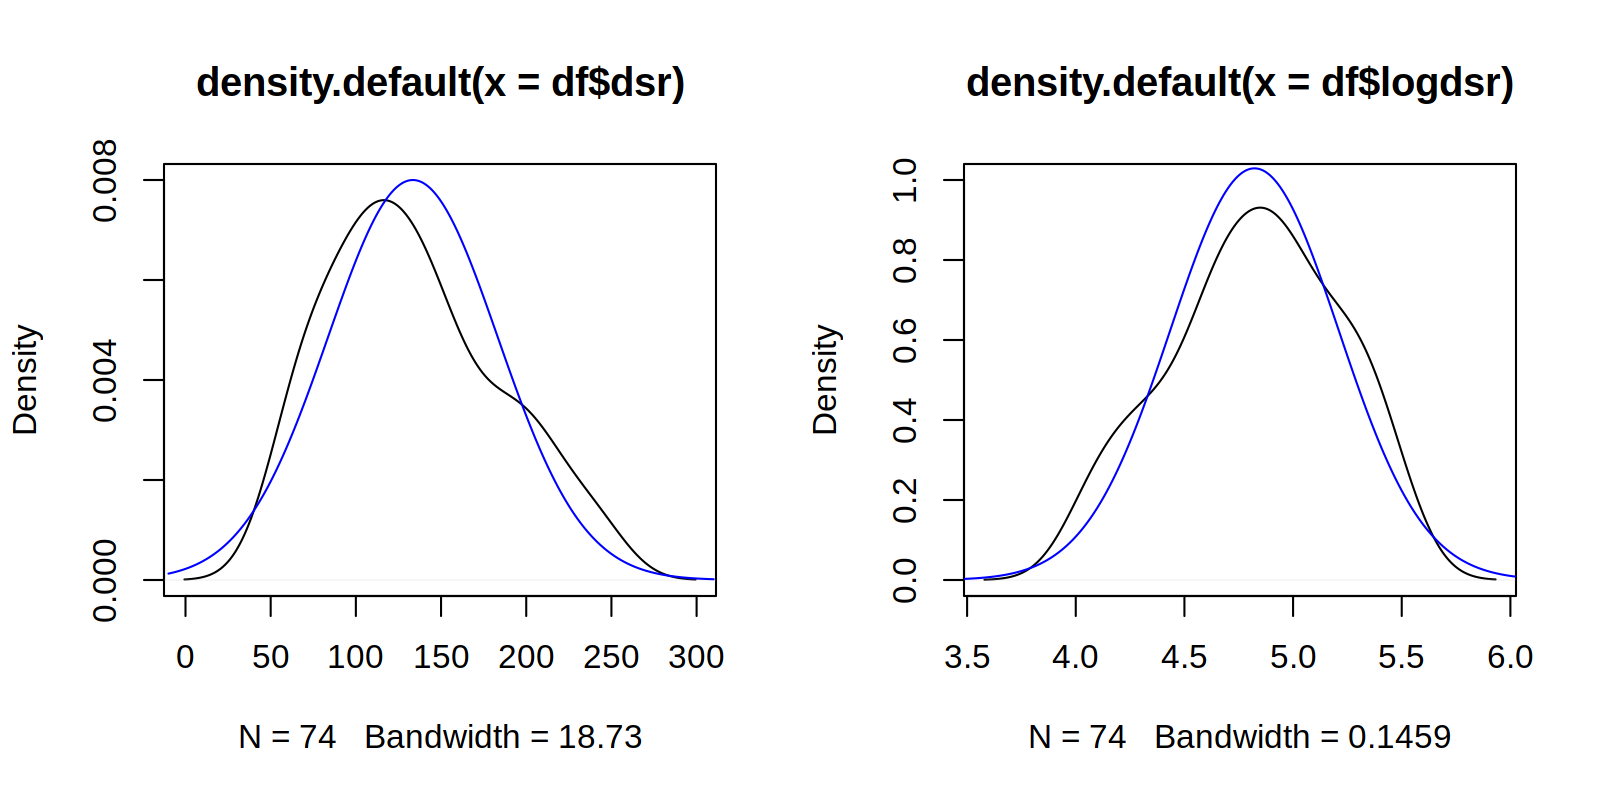

In [3]:
prep_window(c(1,2))

plot(density(df$dsr), ylim = c(0,0.008))
lines(x <- seq(-10,310,1), dnorm(x, mean(df$dsr), sd(df$dsr)), col = "blue")
plot(density(df$logdsr), ylim = c(0,1))
lines(x <- seq(-3,7,0.01), dnorm(x, mean(df$logdsr), sd(df$logdsr)), col = "blue")

## Results with normal fitted to log data

Plots are on log scale  
Results converted to actual % changes  
AIC not comparable to AIC for non-logged data  
Ideally: option to fit & convert (lnorm) or to show results for linear fit to logged data (norm)

In [4]:
mdl_norm <- fit_ns(dist = "norm", type = "shift", data = df, varnm = "logdsr", covnm = "gmst", lower = F)

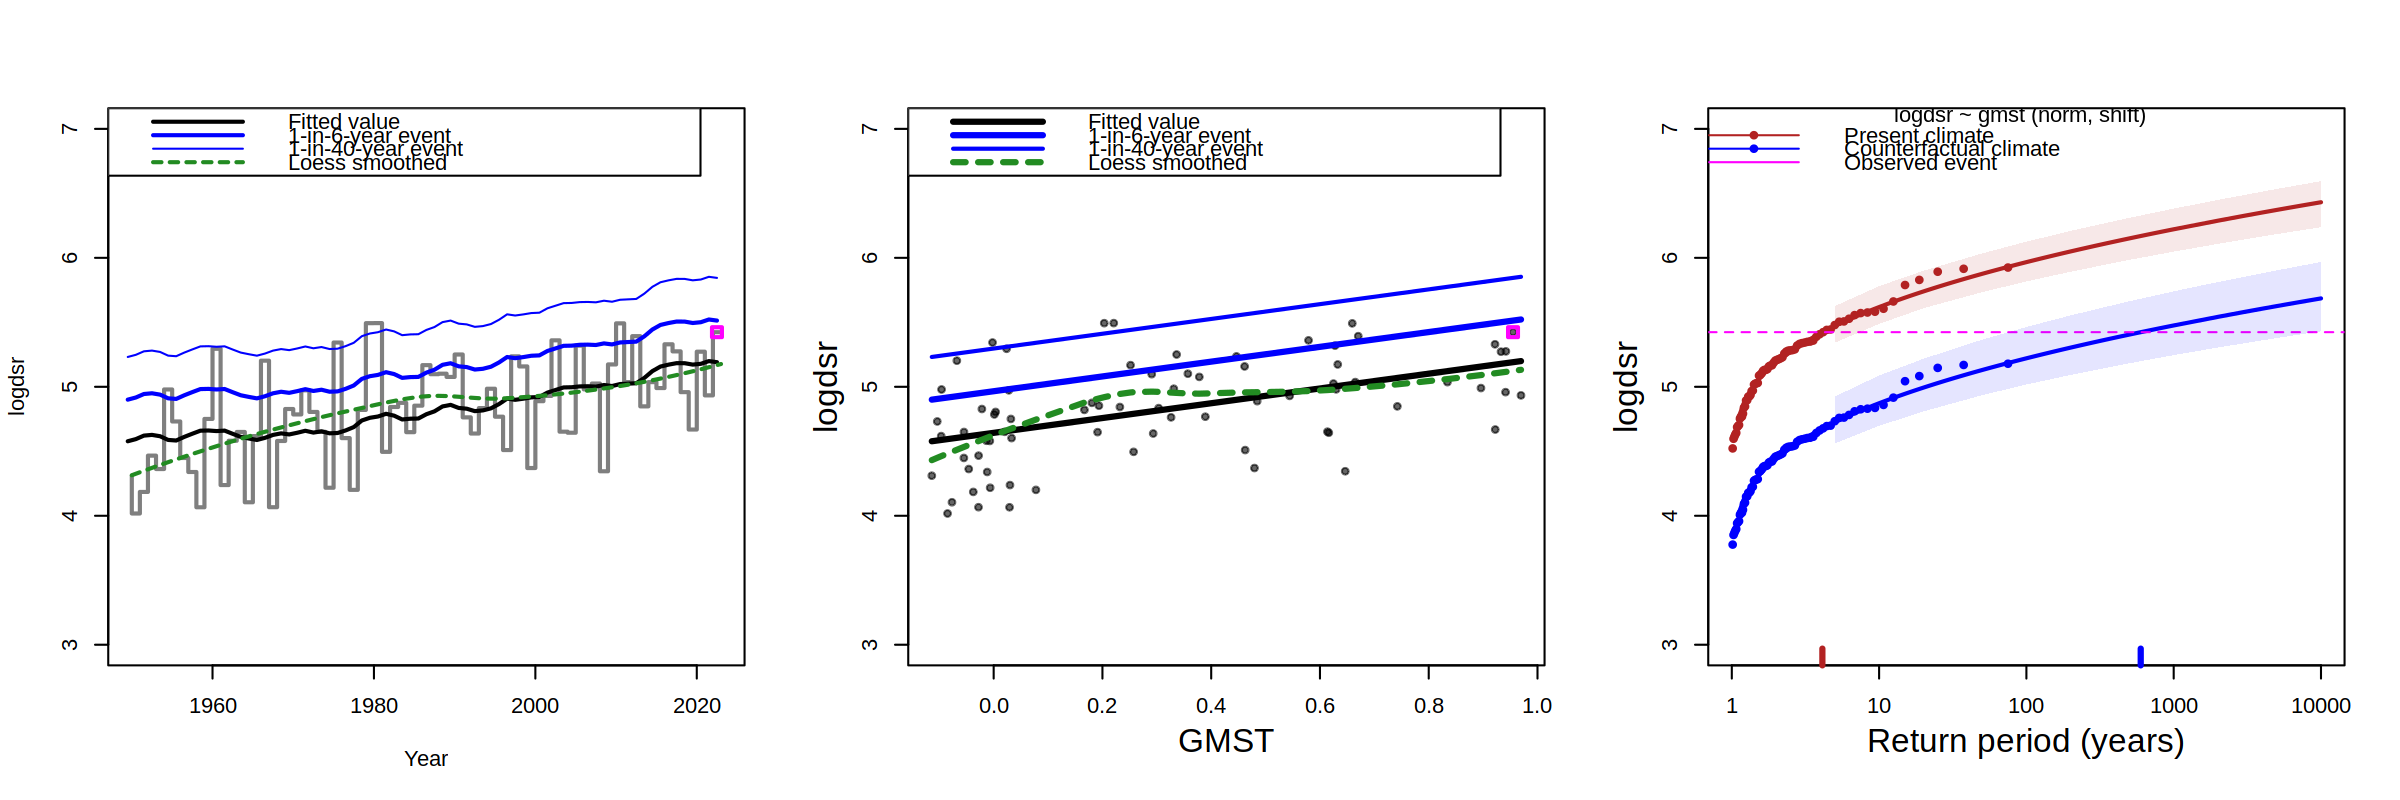

In [5]:
prep_window(c(1,3))
ylim <- c(3,7)
plot_trend(mdl_norm, ylim = ylim)
plot_covtrend(mdl_norm, "gmst", ylim = ylim)
plot_returnlevels(mdl_norm, ylim = ylim, cov_f = cov_2023, cov_cf = cov_pi, nsamp = 50)

In [6]:
boot_ci(mdl_norm, cov_f = cov_2023, cov_cf = cov_pi, nsamp = 50)

,est,2.5%,97.5%
mu0,4.64300091,4.54894262,4.751400e+00
sigma0,0.33349756,0.28882692,3.735762e-01
alpha_gmst,0.57366723,0.38726409,8.151237e-01
disp,0.06424716,0.05523593,7.244521e-02
event_magnitude,5.42349424,5.42349424,5.423494e+00
return_period,4.11997286,2.44649879,7.407298e+00
PR,144.96750597,16.09099727,2.918163e+03
dI_abs,0.74576741,0.50344331,1.059661e+00
dI_rel,15.94294474,10.23290125,2.428280e+01
aic,53.48632283,32.19629163,7.026623e+01


In [7]:
aic(mdl_norm)

[1] 53.48632

# Modified functions for lognormal fitting

- log transformation is carried out within the function

In [25]:
fit_ns <- function(dist, type = "fixeddisp", data, varnm, covnm = NA, lower = F, ev_year = NA, ev = NA, method = "BFGS") {

  # if no covariate name provided, add a dummy covariate & fit stationary series instead
  if(is.na(covnm[1])) {
    data <- cbind(data, "const" = 1)
    covnm <- "const"
  }

  # remove extraneous columns from dataframes
  cov <- data[, covnm, drop = F]
  k <- length(covnm)
  x <- data[,varnm]

  # should also add something to handle case with no covariates
    
  # log-transform data for lognormal fitting
  if (dist %in% c("lnorm")) x <- log(x)

  # currently only works for distributions fully specified by mean & sd: only tested for normal, lognormal
  if(! dist %in% c("norm", "gev", "gumbel", "lnorm", "lognormal")) {
    print("Not yet implemented: use norm or gev")
    return()
  }

  # if looking at lower tail with a GEV, necessary to negate data and consider block maxima - add flag to keep track
  minima <- F
  if (lower & (dist %in% c("gev", "gumbel"))) {
    x <- -x
    minima <- T
  }

  # fit model with appropriate number of parameters, pad if necessary
  init <- c("mu0" = mean(x), "sigma0" = sd(x), setNames(rep(0,k), paste0("alpha_", covnm)))

  if(type %in% c("shiftscale", "shiftscale_linear", "shiftscale_exp")) init <- c(init, setNames(rep(0,k), paste0("beta_", covnm)))

  if(dist %in% c("gev")) init <- c(init, "shape" = 0)
  fitted <- suppressWarnings(optim(par = init, ns_loglik, cov = cov, x = x, dist = dist, fittype = type, method = method))

  # if looking at lower tail with a GEV, necessary to flip data and consider block maxima, so trend & location parameters have been flipped. This may cause some confusion so may have to modify later!
  if(minima) {
    fitted[["NOTE"]] <- "NB: model parameters are estimated for negated values"
    fitted$par["mu0"] <- -fitted$par["mu0"]
    fitted$par[grepl("alpha", names(fitted$par))] <- -fitted$par[grepl("alpha", names(fitted$par))]
    x <- -x
  }

  # attach assorted useful information
  fitted[["dist"]] <- dist
  fitted[["type"]] <- type
  fitted[["varnm"]] <- varnm
  fitted[["covnm"]] <- covnm
  fitted[["data"]] <- data
  fitted[["x"]] <- x
  fitted[["cov"]] <- cov

  fitted[["lower"]] <- lower               # saves having to specify every time later on
  fitted[["minima"]] <- minima             # look at maxima of 0-temps, rather than minima of observed temps

  # event year: assume that event of interest is most recent, unless told otherwise (used in later plotting functions)
  if(is.na(ev_year)) { ev_year <- data$year[length(x)] }
  fitted[["ev_year"]] <- ev_year

  if (ev_year %in% data$year) {
    ev_idx <- which(data$year == ev_year)
  } else {
    ev_idx <- nrow(data)+1
  }

  # event value: assume that event of interest is most recent, unless told otherwise (used in later plotting functions)
  if(is.na(ev)) {
    if(ev_year %in% data$year) {
      ev <- x[data$year == ev_year]
    } else {
      print("WARNING: Event year not in data, no event value recorded")
      ev <- NA
    }
  }
  fitted[["ev"]] <- ev
  fitted[["ev_idx"]] <- ev_idx

  return(fitted)
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ns_loglik <- function(pars, cov, x, dist, fittype) {

  nspars <- get.ns_pars(fittype = fittype, pars = pars, fixed_cov = cov)

  loc <- nspars$loc
  scale <- nspars$scale
  shape <- nspars$shape

  # constrain variance to be strictly positive
  if(any(scale <= 0)) return(NA)

  # return negative log-likelihood
  if (dist %in% c("norm", "lnorm")) {
    return(-sum(dnorm(x, mean = loc, sd = scale, log = T)))
  } else if (dist == "gev") {
    shape = pars["shape"]
    return(-sum(devd(x, loc = loc, scale = scale, shape = shape, log = T)))
  } else if (dist == "gumbel") {
    return(-sum(devd(x, loc = loc, scale = scale, shape = 0, log = T)))
  } else {
    print(paste(dist, "not implemented"))
    return()
  }
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
aic <- function(mdl) {
    nll <- 2 * length(mdl$par) + 2 * mdl$value
    if(mdl$dist %in% c("lnorm")) nll <- nll + 2*sum(log(mdl$x))
    return(nll)
}

In [9]:
map_to_u <- function(mdl, x, fixed_cov = NA) {

  pars <- ns_pars(mdl, fixed_cov = fixed_cov)
  if(missing(x)) x <- mdl$x

  # retrieve the actual fitted model parameters if they were negated for fitting (ie if looking at lower tails of GEV)
  if(mdl$minima) {
    pars$loc <- -pars$loc
    x = -x
    mdl$lower <- !mdl$lower # also have to look at the opposite tail
  }

  # get exceedance probability
  if(mdl$dist %in% c("norm", "lnorm")) {
    pit <- pnorm(x, mean = pars$loc, sd = pars$scale, lower.tail = mdl$lower)
  } else if(mdl$dist == "gev") {
    pit <- sapply(1:length(pars$loc), function(i) pevd(x[i], loc = pars$loc[i], scale = pars$scale[i], shape = pars$shape[i], lower.tail = mdl$lower))
  } else if(mdl$dist == "gumbel") {
    pit <- sapply(1:length(pars$loc), function(i) pevd(x[i], loc = pars$loc[i], scale = pars$scale[i], shape = 0, lower.tail = mdl$lower))
  } else {
    return(NULL)
  }
  return(pit)
}
                  
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
map_from_u <- function(mdl, u, fixed_cov = NA) {
  
  if(missing(u)) u <- map_to_u(mdl, fixed_cov = fixed_cov)
  pars <- ns_pars(mdl, fixed_cov = fixed_cov)
  
  # retrieve the actual fitted model parameters if they were flipped for fitting
  if(mdl$minima) {
    pars$loc <- -pars$loc
    mdl$lower <- !mdl$lower       # also have to look at the opposite tail
  }
  
  # map quantile onto stationary distribution
  if(mdl$dist %in% c("norm", "lnorm")) {
    # erl <- sapply(1:length(u), function(j) {
    #     qnorm(u[j], mean = pars$loc, sd = pars$scale, lower.tail = mdl$lower)
    # })
    erl <- qnorm(u, mean = pars$loc, sd = pars$scale, lower.tail = mdl$lower)
  } else if(mdl$dist == "gev") {
    erl <- sapply(1:length(u), function(j) {
      sapply(1:length(pars$loc), function(i) {
        qevd(u[j], loc = pars$loc[i], scale = pars$scale[i], shape = pars$shape[i], lower.tail = mdl$lower)
      })
    })
  } else if(mdl$dist == "gumbel") {
    erl <- sapply(1:length(u), function(j) {
      sapply(1:length(pars$loc), function(i) {
        qevd(u[j], loc = pars$loc[i], scale = pars$scale[i], shape = 0, lower.tail = mdl$lower)
      })
    })
  } else {
    return(NULL)
  }
  
  # if parameters flipped for fitting, flip 'em back
  if(mdl$minima) erl <- -erl
  
  return(erl)
}
                  
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
int_change <- function(mdl, rp = NA, cov_f, cov_cf, relative = F) {

  if(is.na(rp)) {
    if(relative) {
      cat("Return period needed to calculate relative change")
      return(NA)
    } else {
      rp <- 10
    }
  }
  # if return period is less than 1, assume it's an exceedance probability and convert to a return period
  if(rp < 1) { rp <- 1/rp } else { rp <- rp }

  # get effective return levels
  rl <- eff_return_level(mdl, rp, fixed_cov = cov_f)
  rl_cf <- eff_return_level(mdl, rp, fixed_cov = cov_cf)

  # if variable is logged, convert to real values first
  if(mdl$dist %in% c("lnorm")) {
    rl <- exp(rl)
    rl_cf <- exp(rl_cf)
  }

  if(relative) {
    (rl - rl_cf) / rl_cf * 100
  } else {
    rl - rl_cf
  }
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




In [10]:
mdl_ests <- function(mdl, cov_f, cov_cf, ev, rp = NA) {

  if(nrow(cov_f) > 1) {
    print("cov_f has more than one row: only first row will be used as factual covariates")
    cov_f <- cov_f[1,,drop = F]
  }

  if(!all(c(sapply(mdl$covnm, function(cnm) cnm %in% colnames(cov_f)), sapply(mdl$covnm, function(cnm) cnm %in% colnames(cov_cf))))) {
    print("Not all model covariates appear in factual/counterfactual covariates: missing covariates will be assumed to be zero throughout")
  }

  pars <- mdl$par
  current_pars <- ns_pars(mdl, fixed_cov = cov_f)
  disp <- current_pars$scale / current_pars$loc

  if(is.na(rp)) {
    # if no fixed RP is given, estimate it from the event value
    if(missing(ev)) ev <- mdl$ev
    rp <- return_period(mdl, ev, fixed_cov = cov_f)
  } else {
    # if fixed RP given, use it to bootstrap the expected magnitude of the event value
    ev <- eff_return_level(mdl, rp, fixed_cov = cov_f)
  }

  # loop over counterfactual covariates (if necessary) & get PRs and intensity changes
  if(nrow(cov_cf) == 1) {
      changes <- c("PR" = prob_ratio(mdl, ev, cov_f, cov_cf),
                   "dI_abs" = int_change(mdl, rp, cov_f, cov_cf, relative = F),
                   "dI_rel" = int_change(mdl, rp, cov_f, cov_cf, relative = T))
#                    "dI_abs" = tryCatch(int_change(mdl, rp, cov_f, cov_cf, relative = F), error = function(cond) {return(NA)}),
#                    "dI_rel" = tryCatch(int_change(mdl, rp, cov_f, cov_cf, relative = T), error = function(cond) {return(NA)}))
  } else {
      changes <- unlist(lapply(rownames(cov_cf), function(rnm) {
          pr <- prob_ratio(mdl, ev, cov_f, cov_cf[rnm,,drop = F])
          dI_abs <- int_change(mdl, rp, cov_f, cov_cf[rnm,,drop = F], relative = F)
          dI_rel <- int_change(mdl, rp, cov_f, cov_cf[rnm,,drop = F], relative = T)
#           di_abs <- tryCatch(int_change(mdl, rp, cov_f, cov_cf[rnm,,drop = F], relative = F), error = function(cond) {return(NA)})
#           di_rel <- tryCatch(int_change(mdl, rp, cov_f, cov_cf[rnm,,drop = F], relative = T), error = function(cond) {return(NA)})
          setNames(c(pr, di_abs, di_rel), paste0(c("PR", "dI_abs", "dI_rel"), "_",rnm))
      }))
  }
  if(mdl$dist %in% c("lnorm")) {
      ev <- exp(ev)
      # could also reverse transformation on model parameters, if preferred
  }
  
  return(c(mdl$par, "disp" = disp, "event_magnitude" = ev, "return_period" = rp, changes, "aic" = aic(mdl)))
}

In [11]:
mdl_ests <- function(mdl, cov_f, cov_cf, ev, rp = NA) {

  if(nrow(cov_f) > 1) {
    print("cov_f has more than one row: only first row will be used as factual covariates")
    cov_f <- cov_f[1,,drop = F]
  }

  if(!all(c(sapply(mdl$covnm, function(cnm) cnm %in% colnames(cov_f)), sapply(mdl$covnm, function(cnm) cnm %in% colnames(cov_cf))))) {
    print("Not all model covariates appear in factual/counterfactual covariates: missing covariates will be assumed to be zero throughout")
  }

  pars <- mdl$par
  current_pars <- ns_pars(mdl, fixed_cov = cov_f)
  disp <- current_pars$scale / current_pars$loc

  if(is.na(rp)) {
    # if no fixed RP is given, estimate it from the event value
    if(missing(ev)) ev <- mdl$ev
    rp <- return_period(mdl, ev, fixed_cov = cov_f)
  } else {
    # if fixed RP given, use it to bootstrap the expected magnitude of the event value
    ev <- eff_return_level(mdl, rp, fixed_cov = cov_f)
  }

  # loop over counterfactual covariates (if necessary) & get PRs and intensity changes
  if(nrow(cov_cf) == 1) {
      changes <- c("PR" = prob_ratio(mdl, ev, cov_f, cov_cf),
                   "dI_abs" = tryCatch(int_change(mdl, rp, cov_f, cov_cf, relative = F), error = function(cond) {return(NA)}),
                   "dI_rel" = tryCatch(int_change(mdl, rp, cov_f, cov_cf, relative = T), error = function(cond) {return(NA)}))
  } else {
      changes <- unlist(lapply(rownames(cov_cf), function(rnm) {
          pr <- prob_ratio(mdl, ev, cov_f, cov_cf[rnm,,drop = F])
          di_abs <- tryCatch(int_change(mdl, rp, cov_f, cov_cf[rnm,,drop = F], relative = F), error = function(cond) {return(NA)})
          di_rel <- tryCatch(int_change(mdl, rp, cov_f, cov_cf[rnm,,drop = F], relative = T), error = function(cond) {return(NA)})
          setNames(c(pr, di_abs, di_rel), paste0(c("PR", "dI_abs", "dI_rel"), "_",rnm))
      }))
  }
  if(mdl$dist %in% c("lnorm")) {
      ev <- exp(ev)
      # could also reverse transformation on model parameters, if preferred
  }
  
  return(c(mdl$par, "disp" = disp, "event_magnitude" = ev, "return_period" = rp, changes, "aic" = aic(mdl)))
}

In [12]:
# no change needed but have to reload anyway
return_period <- function(mdl, x, fixed_cov = NA) {
  1 / map_to_u(mdl, x, fixed_cov)
}
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

prob_ratio <- function(mdl, ev, cov_f, cov_cf) {

  if(missing(ev)) ev <- mdl$ev

  ep_f <- map_to_u(mdl, ev, fixed_cov = cov_f)
  ep_cf <- map_to_u(mdl, ev, fixed_cov = cov_cf)

  ep_f / ep_cf
}
                                                                              
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
eff_return_level <- function(mdl, rp, fixed_cov = NA) {

  map_from_u(mdl, 1/rp, fixed_cov = fixed_cov)
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
refit <- function(mdl, new_data) {
  fit_ns(dist = mdl$dist, type = mdl$type, data = new_data, varnm = mdl$varnm, covnm = mdl$covnm, lower = mdl$lower, ev = mdl$ev)
}

## Compare results

In [18]:
mdl_lnorm <- fit_ns(dist = "lnorm", type = "shift", data = df, varnm = "dsr", covnm = "gmst", lower = F)

In [19]:
rbind("norm" = mdl_ests(mdl_norm, cov_f = cov_2023, cov_cf = cov_pi),
      "lnorm" = mdl_ests(mdl_lnorm, cov_f = cov_2023, cov_cf = cov_pi))

,mu0,sigma0,alpha_gmst,disp,event_magnitude,return_period,PR,dI_abs,dI_rel,aic
norm,4.643001,0.3334976,0.5736672,0.06424716,5.423494,4.119973,144.9675,0.7457674,15.94294,53.48632
lnorm,4.643001,0.3334976,0.5736672,0.06424716,226.669780,4.119973,144.9675,119.1444079,110.80585,285.84792


# PLOTTING

In [84]:
plot_trend <- function(mdl, ev, ev_year, rp = c(6, 40), add_loess = T, loess_col = "forestgreen",
                       xlab = "Year", ylab = NA, legend_pos = "topleft", main = "", xlim = NA, ylim = NA, lwd = 2) {

  if(is.na(ylab)) {ylab <- mdl$varnm}
  if(is.na(unlist(xlim)[1])) { xlim <- range(mdl$data$year) }
  if(is.na(unlist(ylim)[1])) { ylim <- range(pretty(mdl$data[,mdl$varnm])) }
  if(missing(ev)) { ev <- mdl$ev }
  if(missing(ev_year)) { ev_year <- mdl$data$year[which.min(abs(mdl$x - ev))] }

  # set up legend
  legend_labels = "Fitted value"
  legend_cols = "black"
  legend_lty = "solid"
  legend_lwd = lwd

  # modify legend if adding effective return levels
  rp <- unique(rp[!is.na(rp)])
  if(length(rp) > 0) {
    legend_labels = c(legend_labels, paste0("1-in-",rp,"-year event"))
    legend_cols = c(legend_cols, rep("blue",length(rp)))
    legend_lty = c(legend_lty, rep("solid",length(rp)))
    legend_lwd = c(legend_lwd,c(lwd,max(1,lwd -1))[1:length(rp)])
  }

  plot(mdl$data$year, mdl$data[,mdl$varnm], type = "S", lwd = lwd, col = adjustcolor("black", 0.5), xlab = xlab,
       ylab = ylab, main = main, xlim = xlim, ylim = ylim)
    
  loc <- ns_pars(mdl)$loc
  rl1 <- eff_return_level(mdl, rp[1])
  rl2 <- eff_return_level(mdl, rp[2])
    
  if (mdl$dist %in% c("lnorm")) {
      loc <- exp(loc); rl1 <- exp(rl1); rl2 <- exp(rl2); ev <- exp(ev)
  }

  lines(mdl$data$year-0.5, loc, col = adjustcolor("black", 1), lwd = lwd)
  lines(mdl$data$year-0.5, rl1, type = "l", lty = 1, col = adjustcolor("blue", 1), lwd = lwd)
  lines(mdl$data$year-0.5, rl2, type = "l", lty = 1, col = adjustcolor("blue", 1), lwd = max(1,lwd -1))

  # add a loess smoother
  if(add_loess) {
    lines(mdl$data$year, fitted(loess(formula(paste0(mdl$varnm," ~ year")), mdl$data)), col = loess_col, lwd = lwd, lty = "22")
    legend_labels <- c(legend_labels, "Loess smoothed")
    legend_cols <- c(legend_cols, loess_col)
    legend_lty <- c(legend_lty, "22")
    legend_lwd <- c(legend_lwd, lwd)
  }

  points(ev_year-0.5, ev, col = "magenta", lwd = 2, pch = 0)

  # add legend
  legend(legend_pos, legend = legend_labels, lty = legend_lty, col = legend_cols, lwd = legend_lwd)
}

In [85]:
plot_covtrend <- function(mdl, xcov, trend_cov = NA, ci_cov = NA,  ci_col = "black", ev, ev_x, rp = c(6,40), add_loess = T, loess_col = "forestgreen",
                          seed = 42, nsamp = 500, xlim = NA, ylim = NA, xlab = NA, ylab = NA, legend_pos = "topleft", main = "", lwd = 3) {

  if(is.na(xlab)) { xlab <- toupper(xcov)}
  if(is.na(ylab)) { ylab <- mdl$varnm}
  if(is.na(ylim[1])) { ylim <- range(pretty(mdl$data[,mdl$varnm])) }
  if(missing(ev)) { ev <- mdl$ev }

  x <- mdl$data[,xcov]
  if(missing(ev))    { ev <- mdl$ev }
  if(missing(ev_x)) { ev_x <- x[mdl$ev_idx] }
  o <- order(x)

  if(is.na(unlist(ci_cov)[1])) {
    # can't plot confidence intervals so set nsamp to NA
    nsamp <- NA
    xlims <- range(x)
  } else {
    # extend the x-axis to accommodate the CI covariates
    xlims <- range(pretty(c(ci_cov[,xcov], x)))

    # if only the x-covariate is provided, set the other covariates to the mean value for plotting
    for(cnm in mdl$covnm) {
      if(!cnm %in% colnames(ci_cov)) ci_cov[,cnm] <- mean(mdl$data[,cnm])
    }
  }
  if(is.na(unlist(xlim)[1])) xlim <- xlims

  if(is.na(unlist(trend_cov)[1])) {
    # if no plotting covariate provided, fix all covariates at mean value except for xcov
    trend_cov <- data.frame(sapply(mdl$covnm, function(cnm) if(cnm == xcov) {mdl$data[,cnm]} else {mean(mdl$data[,cnm])}, simplify = F))
  }

  # set up legend
  legend_labels = "Fitted value"
  legend_cols = "black"
  legend_lty = "solid"
  legend_lwd = lwd

  # modify legend if adding effective return levels
  rp <- unique(rp[!is.na(rp)])
  if(length(rp) > 0) {
    legend_labels = c(legend_labels, paste0("1-in-",rp,"-year event"))
    legend_cols = c(legend_cols, rep("blue",length(rp)))
    legend_lty = c(legend_lty, rep("solid",length(rp)))
    legend_lwd = c(legend_lwd,c(lwd,max(1,lwd -1))[1:length(rp)])
  }

  plot(x, mdl$data[,mdl$varnm], pch = 20, main = main, xlab = "", ylab = "", ylim = ylim, xlim = xlim,
       col = adjustcolor("black", 0.6))
  mtext(xlab, side = 1, line = 2.5, cex = par("cex.lab"))
  mtext(ylab, side = 2, line = 2.5, cex = par("cex.lab"))
                                   
  loc <- ns_pars(mdl, fixed_cov = trend_cov)$loc[o]
  rl1 <- eff_return_level(mdl, rp[1], fixed_cov = trend_cov)[o]
  rl2 <- eff_return_level(mdl, rp[2], fixed_cov = trend_cov)[o]
                                   
  if (mdl$dist %in% c("lnorm")) {
      loc <- exp(loc); rl1 <- exp(rl1); rl2 <- exp(rl2); ev <- exp(ev)
  }

  points(ev_x, ev, col = "magenta", lwd = 2, pch = 0)

  # trend lines
  lines(x[o], loc, lwd = 3, col = "black", lty = 1)
  lines(x[o], rl1, col = "blue", lwd = 3, lty = 1)
  lines(x[o], rl2, col = "blue", lwd = 2, lty = 1)

  # get confidence interval for mu' (if not required, set ci_cov to NA)
  if(!is.na(nsamp)) {
    mdl_df <- mdl$data
    set.seed(seed)
    mu_ci <- apply(sapply(1:nsamp, function(i) {
      boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
      tryCatch({
        boot_mdl <- refit(mdl, boot_df)
        sapply(rownames(ci_cov), function(rnm) ns_pars(boot_mdl, ci_cov[rnm,,drop = F])$loc)
      }, error = function(cond) {return(rep(NA, nrow(ci_cov)))})
    }), 1, quantile, c(0.025, 0.975), na.rm = T)
        
    if (mdl$dist %in% c("lnorm")) {
        # confidence interval & markers for mu' at factual & counterfactual covariates
        segments(x0 = ci_cov[,xcov], y0 = exp(mu_ci["2.5%",]), y1 = exp(mu_ci["97.5%",]), lwd = 3, col = ci_col, lend = 1)
        # matplot(ci_cov[,"gmst"], t(mu_ci), pch = 3, add = T, col = "red3") # line ends: not very elegant, so removed for now
        points(ci_cov[,xcov], sapply(rownames(ci_cov), function(rnm) exp(ns_pars(mdl, ci_cov[rnm,,drop = F])$loc)), pch = "_", col = ci_col, lwd = 2)
    } else {
        # confidence interval & markers for mu' at factual & counterfactual covariates
        segments(x0 = ci_cov[,xcov], y0 = mu_ci["2.5%",], y1 = mu_ci["97.5%",], lwd = 3, col = ci_col, lend = 1)
        # matplot(ci_cov[,"gmst"], t(mu_ci), pch = 3, add = T, col = "red3") # line ends: not very elegant, so removed for now
        points(ci_cov[,xcov], sapply(rownames(ci_cov), function(rnm) ns_pars(mdl, ci_cov[rnm,,drop = F])$loc), pch = "_", col = ci_col, lwd = 2)
    }
  }

  # add a loess smoother
  if(add_loess) {
    dfx <- mdl$data[order(mdl$data[,xcov]),]
    lines(dfx[,xcov], fitted(loess(formula(paste0(mdl$varnm," ~ ", xcov)), dfx)), col = loess_col, lwd = lwd, lty = "22")
    legend_labels <- c(legend_labels, "Loess smoothed")
    legend_cols <- c(legend_cols, loess_col)
    legend_lty <- c(legend_lty, "22")
    legend_lwd <- c(legend_lwd, lwd)
  }

  # add legend
  legend(legend_pos, legend = legend_labels, lty = legend_lty, col = legend_cols, lwd = legend_lwd, cex = par()$cex.lab)
}

In [102]:
plot_returnlevels <- function(mdl, cov_f, cov_cf, ev, seed = 42, nsamp = 500, model_desc = T,
                              xlim = c(1,10000), ylim = NA, pch = 20, xlab = "Return period (years)", ylab = NA, main = "",
                              legend_pos = "topright", legend_labels = c("Present climate", "Counterfactual climate")) {

  x <- mdl$x
  if(missing(ev)) { ev <- mdl$ev }

  rp_x <- unique(c(seq(1.1,2,0.1), seq(2,100,1), seq(100,1000,10), seq(100,1000,100), seq(1000,10000,1000)))     # return periods at which to calculate values for curves
  rp_th <- 1/seq(1,0,length.out = length(x)+2)[2:(length(x)+1)]                                                  # quantiles to map against observations to check fit

  # trim covariates if necessary
  if(nrow(cov_f) > 1) {
    print("cov_f has more than one row: only first row will be used as factual covariates")
    cov_f <- cov_f[1,,drop = F]
  }
  # trim covariates if necessary
  if(nrow(cov_cf) > 1) {
    print("cov_cf has more than one row: only first row will be used as counterfactual covariates")
    cov_cf <- cov_cf[1,,drop = F]
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # calculate return periods & return levels

  rl_curve_pres <- map_from_u(mdl, 1/rp_x, fixed_cov = cov_f)
  rl_curve_cf <- map_from_u(mdl, 1/rp_x, fixed_cov = cov_cf)

  rl_obs_pres <- map_from_u(mdl, map_to_u(mdl), fixed_cov = cov_f)
  rl_obs_cf <- map_from_u(mdl, map_to_u(mdl), fixed_cov = cov_cf)

  rp_event_pres <- 1/map_to_u(mdl, ev, fixed_cov = cov_f)
  rp_event_cf <- 1/map_to_u(mdl, ev, fixed_cov = cov_cf)
    
  if (mdl$dist %in% c("lnorm")) {
      rl_curve_pres <- exp(rl_curve_pres)
      rl_curve_cf <- exp(rl_curve_cf)
      rl_obs_pres <- exp(rl_obs_pres)
      rl_obs_cf <- exp(rl_obs_cf)
      rp_event_pres <- exp(rp_event_pres)
      rp_event_cf <- exp(rp_event_cf)
      ev <- exp(ev)
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # prep axes

  if(is.na(ylim[1])) { ylim <- range(pretty(c(x, rl_curve_pres, rl_curve_cf))) }
  if(is.na(ylab)) {ylab <- mdl$varnm}

  # plot
  plot(0,type = "n", xlim = xlim, ylim = ylim, log = "x", xlab = "", ylab = "", main = main)
  mtext(xlab, side = 1, line = 2.5, cex = par("cex.lab"))
  mtext(ylab, side = 2, line = 2.5, cex = par("cex.lab"))

  # if model description is required, add it as legend title
  if(model_desc) {
    legend_title <- paste0(mdl$varnm, " ~ ", paste0(mdl$covnm, collapse = " + "), " (",mdl$dist, ", ", mdl$type, ")")
  } else {
    legend_title <- ""
  }

  # add legend
  legend(legend_pos, legend = c(legend_labels, "Observed event"), col = c("firebrick", "blue", "magenta"), lty = 1, pch = c(pch,pch,NA),
         bty = "n", cex = par()$cex.lab, title = legend_title)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  # return period curves
  lines(rp_x, rl_curve_pres, lwd = 2, col = "firebrick", lty = 1)       # present climate
  lines(rp_x, rl_curve_cf, lwd = 2, col = "blue", lty = 1)              # counterfactual

  # expected return periods vs return levels transformed to stationarity at that covariate value
  points(rp_th, sort(rl_obs_pres, decreasing = mdl$lower), col = "firebrick", pch = pch)      # present
  points(rp_th, sort(rl_obs_cf, decreasing = mdl$lower), col = "blue", pch = pch)             # counterfactual

  # horizontal line showing observed event, plus ticks showing return periods
  abline(h = ev, col = "magenta", lty = 2)
  suppressWarnings(rug(rp_event_pres, lwd = 3, col = "firebrick"))   # present
  suppressWarnings(rug(rp_event_cf, lwd = 3, col = "blue"))          # counterfactual

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # Add confidence intervals to return periods

  if(!is.na(nsamp)) {
    x_ci <- c(5,10,20,50,100,200,500,1000,2000,5000,10000)
    set.seed(seed)

    mdl_df <- mdl$data
    boot_res <- sapply(1:nsamp, function(i) {
      boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
      tryCatch({
        boot_mdl <- refit(mdl, boot_df)
        # print(boot_mdl$par)
        c(map_from_u(boot_mdl, 1/x_ci, fixed_cov = cov_f), map_from_u(boot_mdl, 1/x_ci, fixed_cov = cov_cf))
      }, error = function(cond) {return(rep(NA, length(x_ci)*2))})
    })
    est_ci <- apply(boot_res, 1, quantile, c(0.025, 0.975), na.rm = T)
    if (mdl$dist %in% c("lnorm")) est_ci <- exp(est_ci)

    # shaded region for confidence intervals
    polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1,1:length(x_ci)], rev(est_ci[2,1:length(x_ci)])), density = NULL, border = NA, col = adjustcolor("firebrick", 0.1))
    polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1,-(1:length(x_ci))], rev(est_ci[2,-(1:length(x_ci))])), density = NULL, border = NA, col = adjustcolor("blue", 0.1))
  }
}                                  
                                     

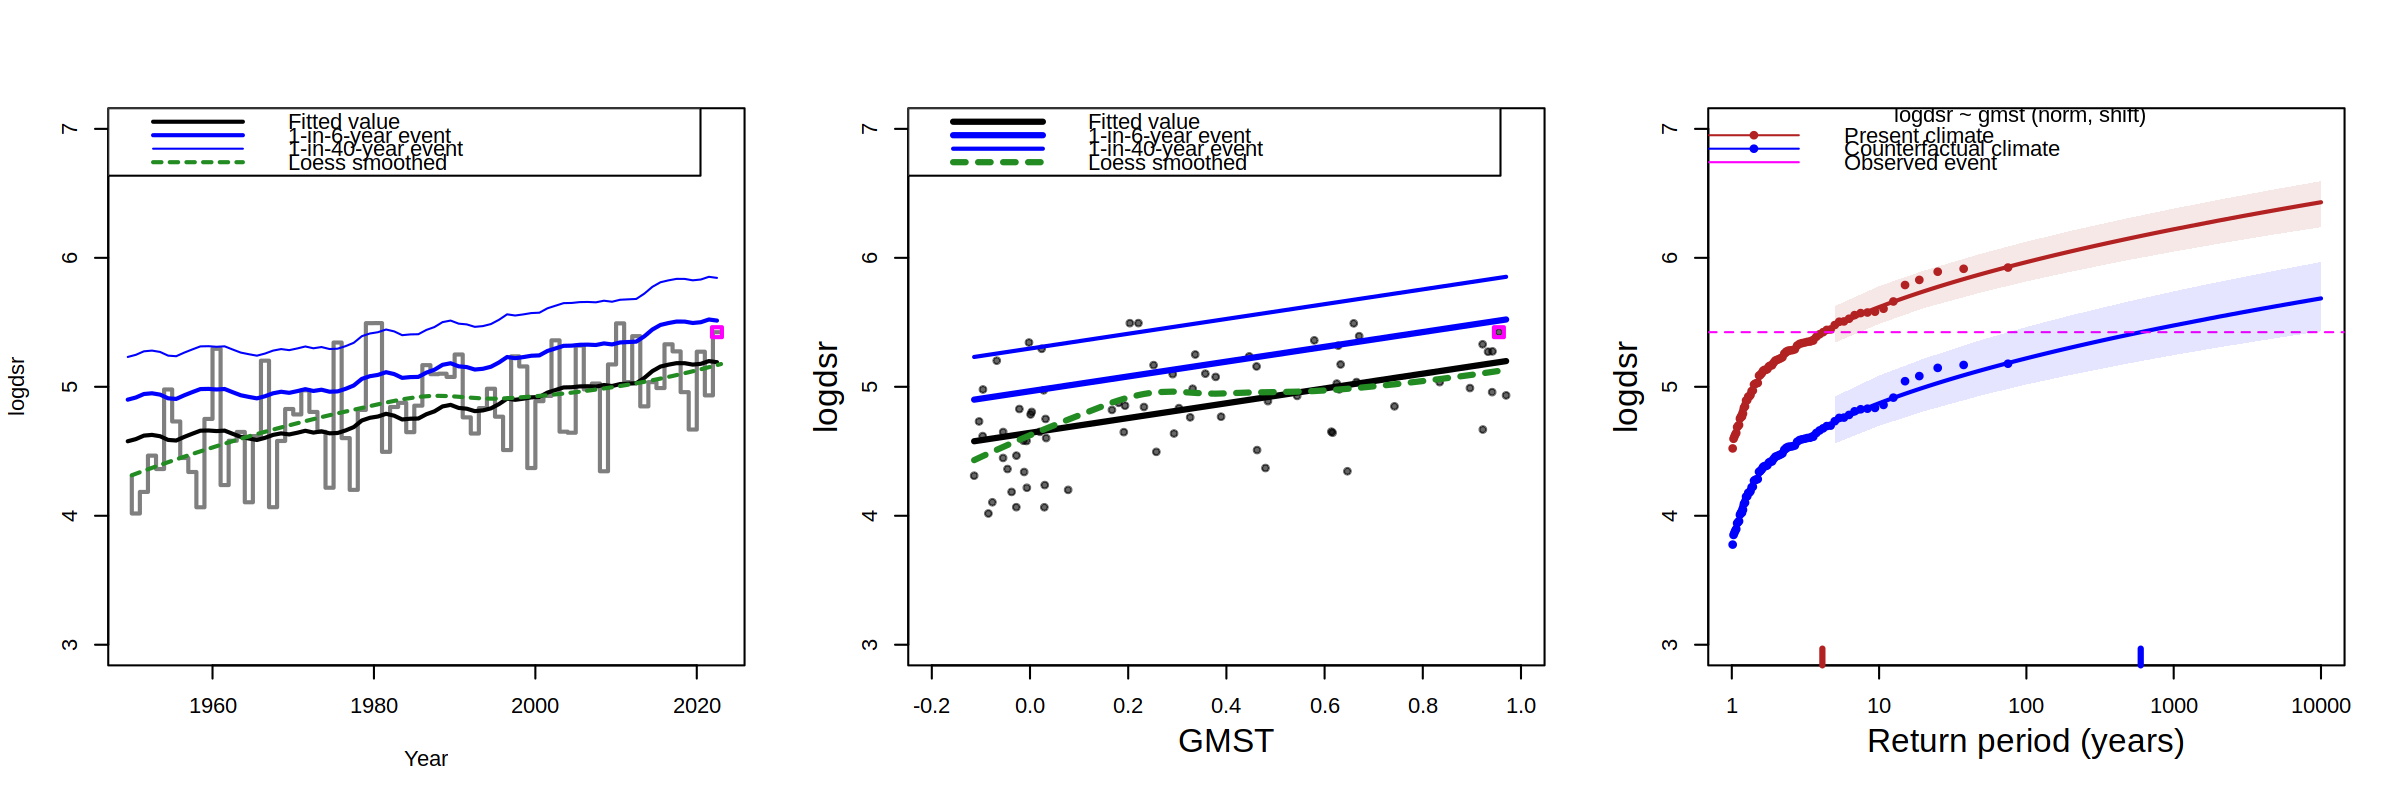

In [103]:
prep_window(c(1,3))
ylim <- c(3,7)
plot_trend(mdl_norm, ylim = ylim)
plot_covtrend(mdl_norm, "gmst", ylim = ylim, ci_cov = data.frame(gmst = c(0, 1)), nsamp = NA)
plot_returnlevels(mdl_norm, ylim = ylim, cov_f = cov_2023, cov_cf = cov_pi, nsamp = 50)

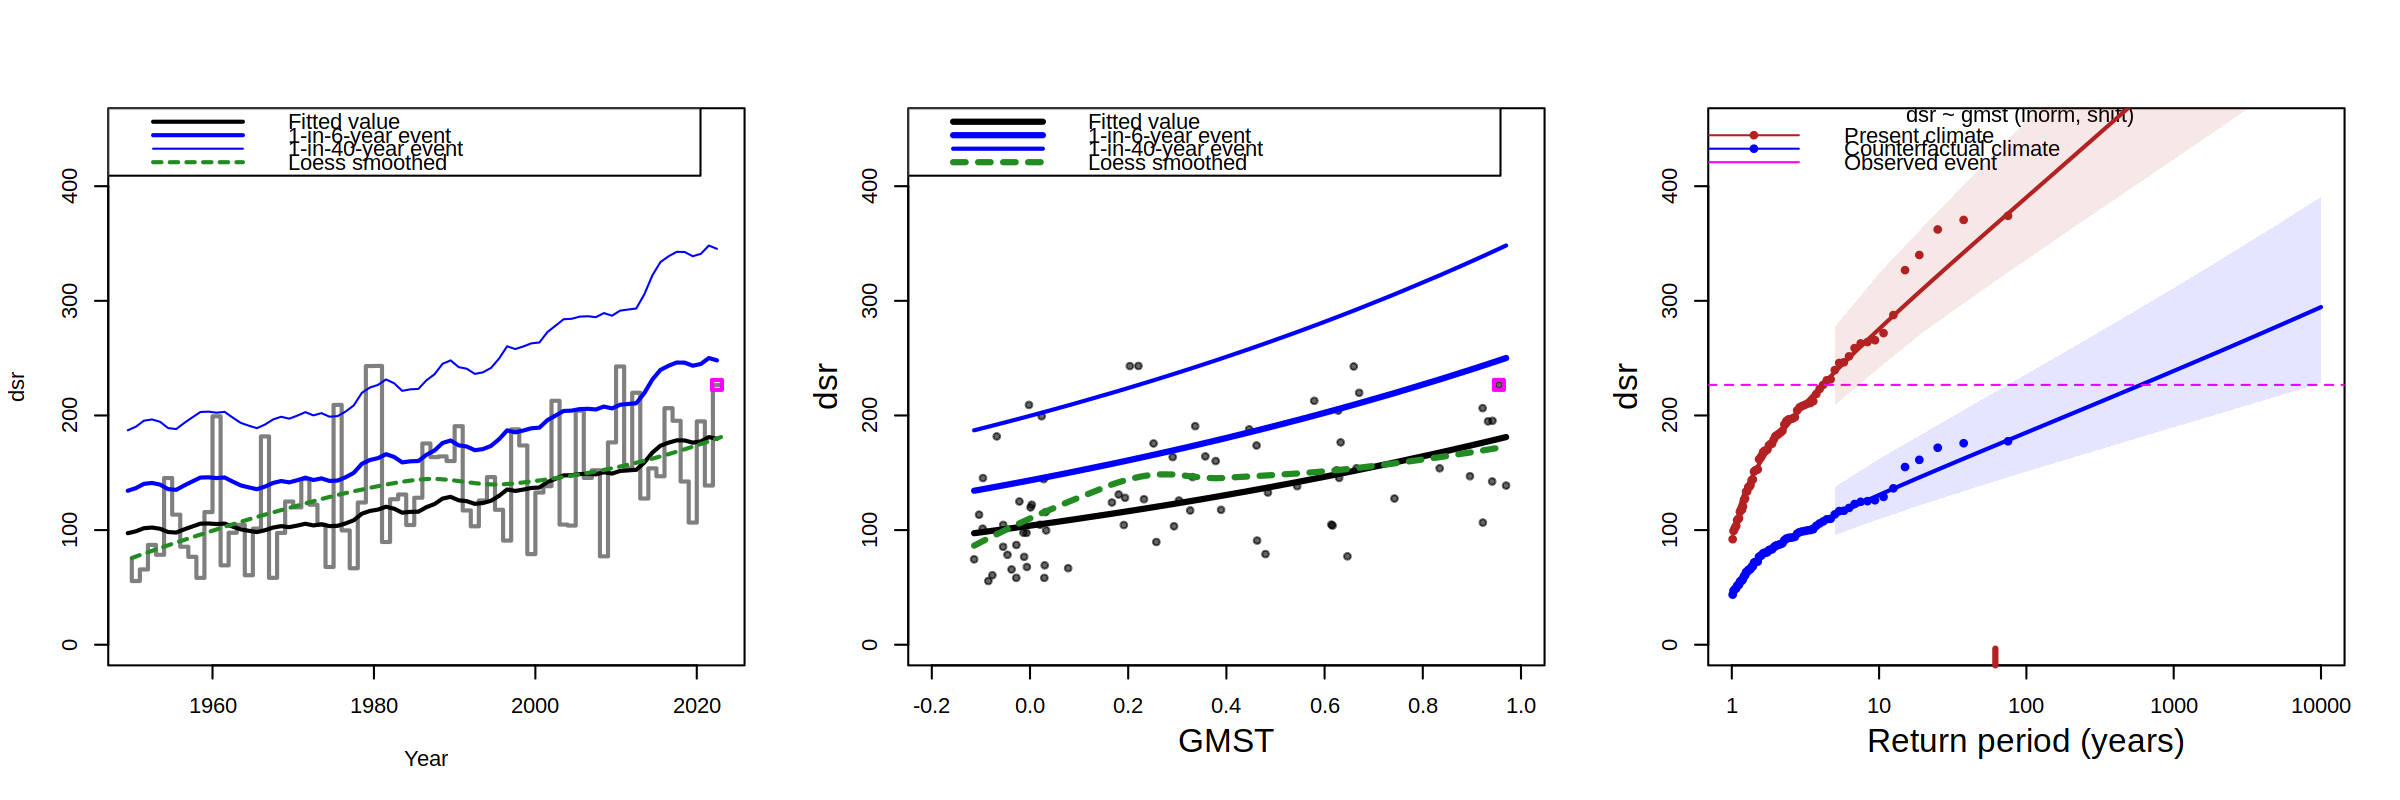

In [105]:
prep_window(c(1,3))
ylim <- c(0,450)

mdl <- mdl_lnorm

plot_trend(mdl_lnorm, ylim = ylim)
plot_covtrend(mdl_lnorm, xcov = "gmst", ylim = ylim, ci_cov = data.frame(gmst = c(0, 1)), nsamp = NA)
plot_returnlevels(mdl_lnorm, ylim = ylim, cov_f = cov_2023, cov_cf = cov_pi, nsamp = 50)

# Check results from revised methods


In [2]:
df <- merge(read.table("gmst.txt", col.names = c("year", "gmst")), read.csv("dsr-yearly-by-ecozone_era5.csv"))[,c("year", "gmst", "BSW")]
colnames(df)[3] <- "dsr"
df$logdsr <- log(df$dsr)

cov_2023 <- df[df$year == 2023,"gmst",drop = F]
cov_pi <- cov_2023 - 1.3

In [3]:
mdl_norm <- fit_ns(dist = "norm", type = "shift", data = df, varnm = "dsr", covnm = "gmst", lower = F)
mdl_lnorm <- fit_ns(dist = "lnorm", type = "shift", data = df, varnm = "dsr", covnm = "gmst", lower = F)

In [4]:
rbind("norm" = mdl_ests(mdl_norm, cov_f = cov_2023, cov_cf = cov_pi),
      "lnorm" = mdl_ests(mdl_lnorm, cov_f = cov_2023, cov_cf = cov_pi))

,mu0,sigma0,alpha_gmst,disp,event_magnitude,return_period,PR,dI_abs,dI_rel,aic
norm,111.681466,43.5960913,69.7373545,0.24453632,226.6698,7.489965,187.3299,90.65856,66.65521,774.6828
lnorm,4.643001,0.3334976,0.5736672,0.06424716,226.6698,4.119973,144.9675,119.14441,110.80585,285.8479


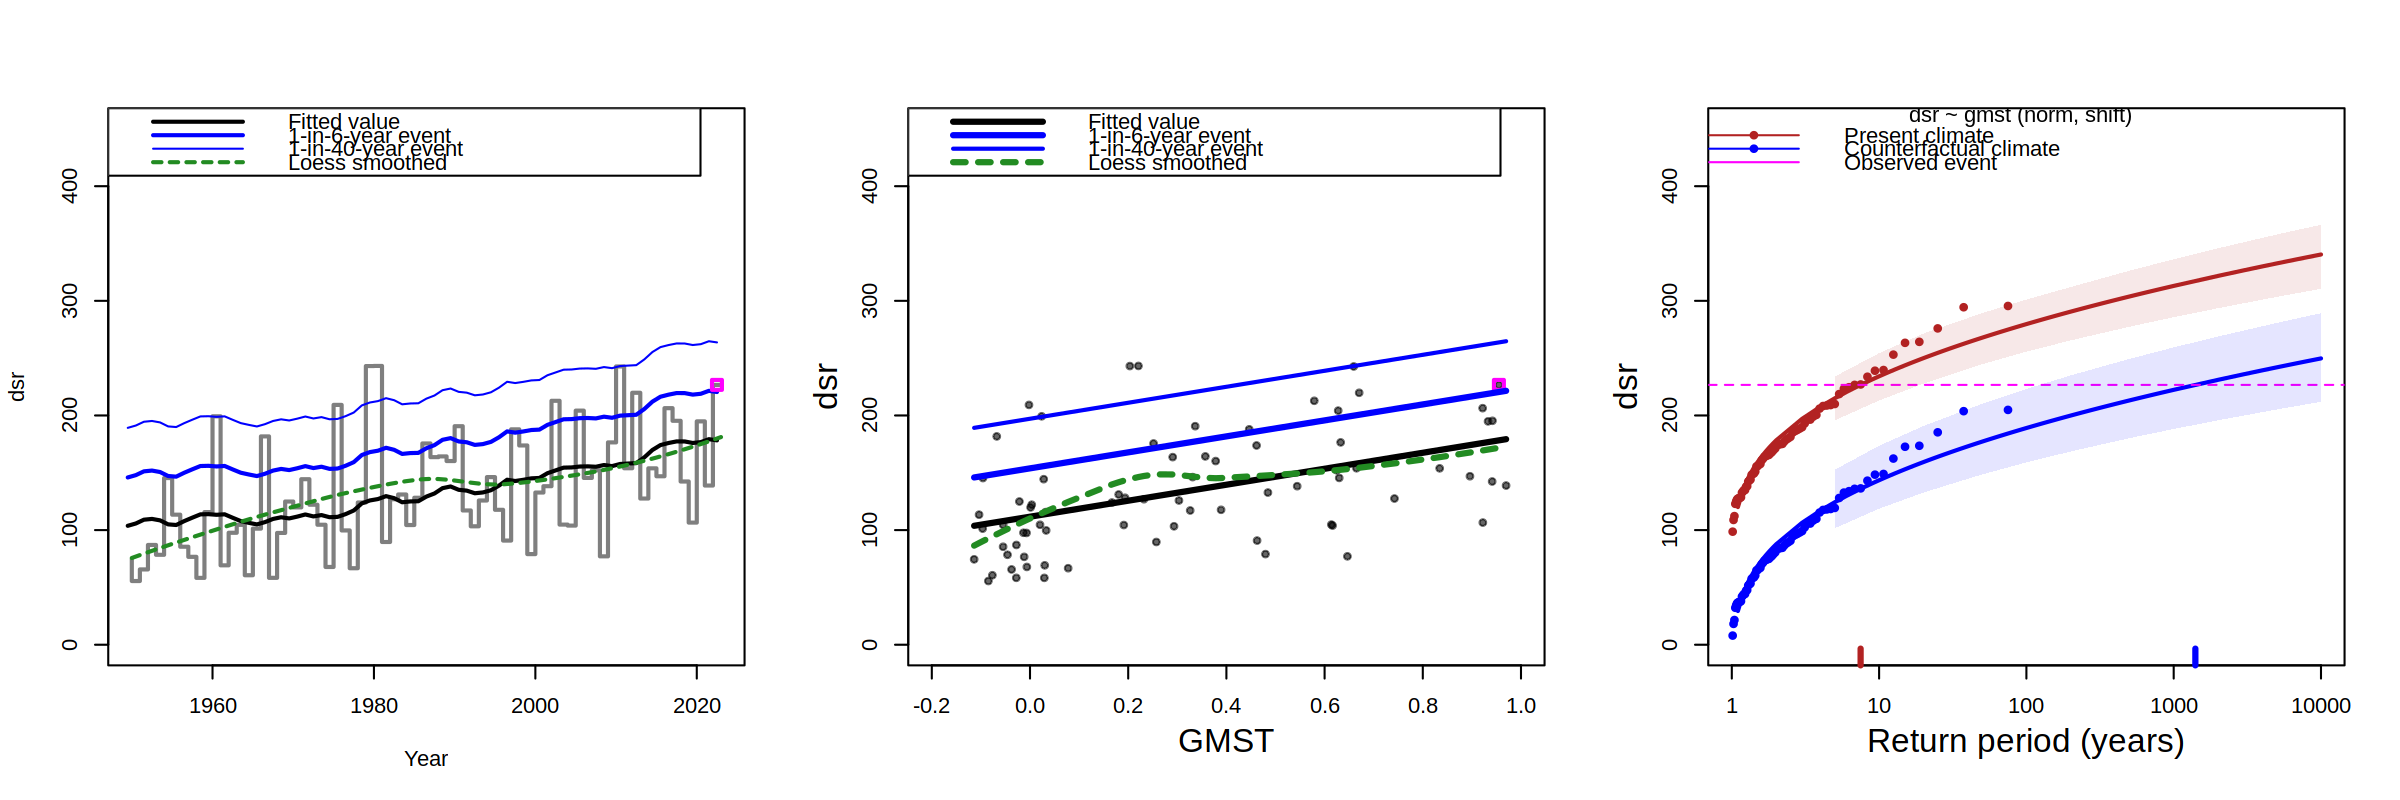

In [7]:
prep_window(c(1,3))
ylim <- c(0,450)
plot_trend(mdl_norm, ylim = ylim)
plot_covtrend(mdl_norm, "gmst", ylim = ylim, ci_cov = data.frame(gmst = c(0, 1)), nsamp = NA)
plot_returnlevels(mdl_norm, ylim = ylim, cov_f = cov_2023, cov_cf = cov_pi, nsamp = 50)

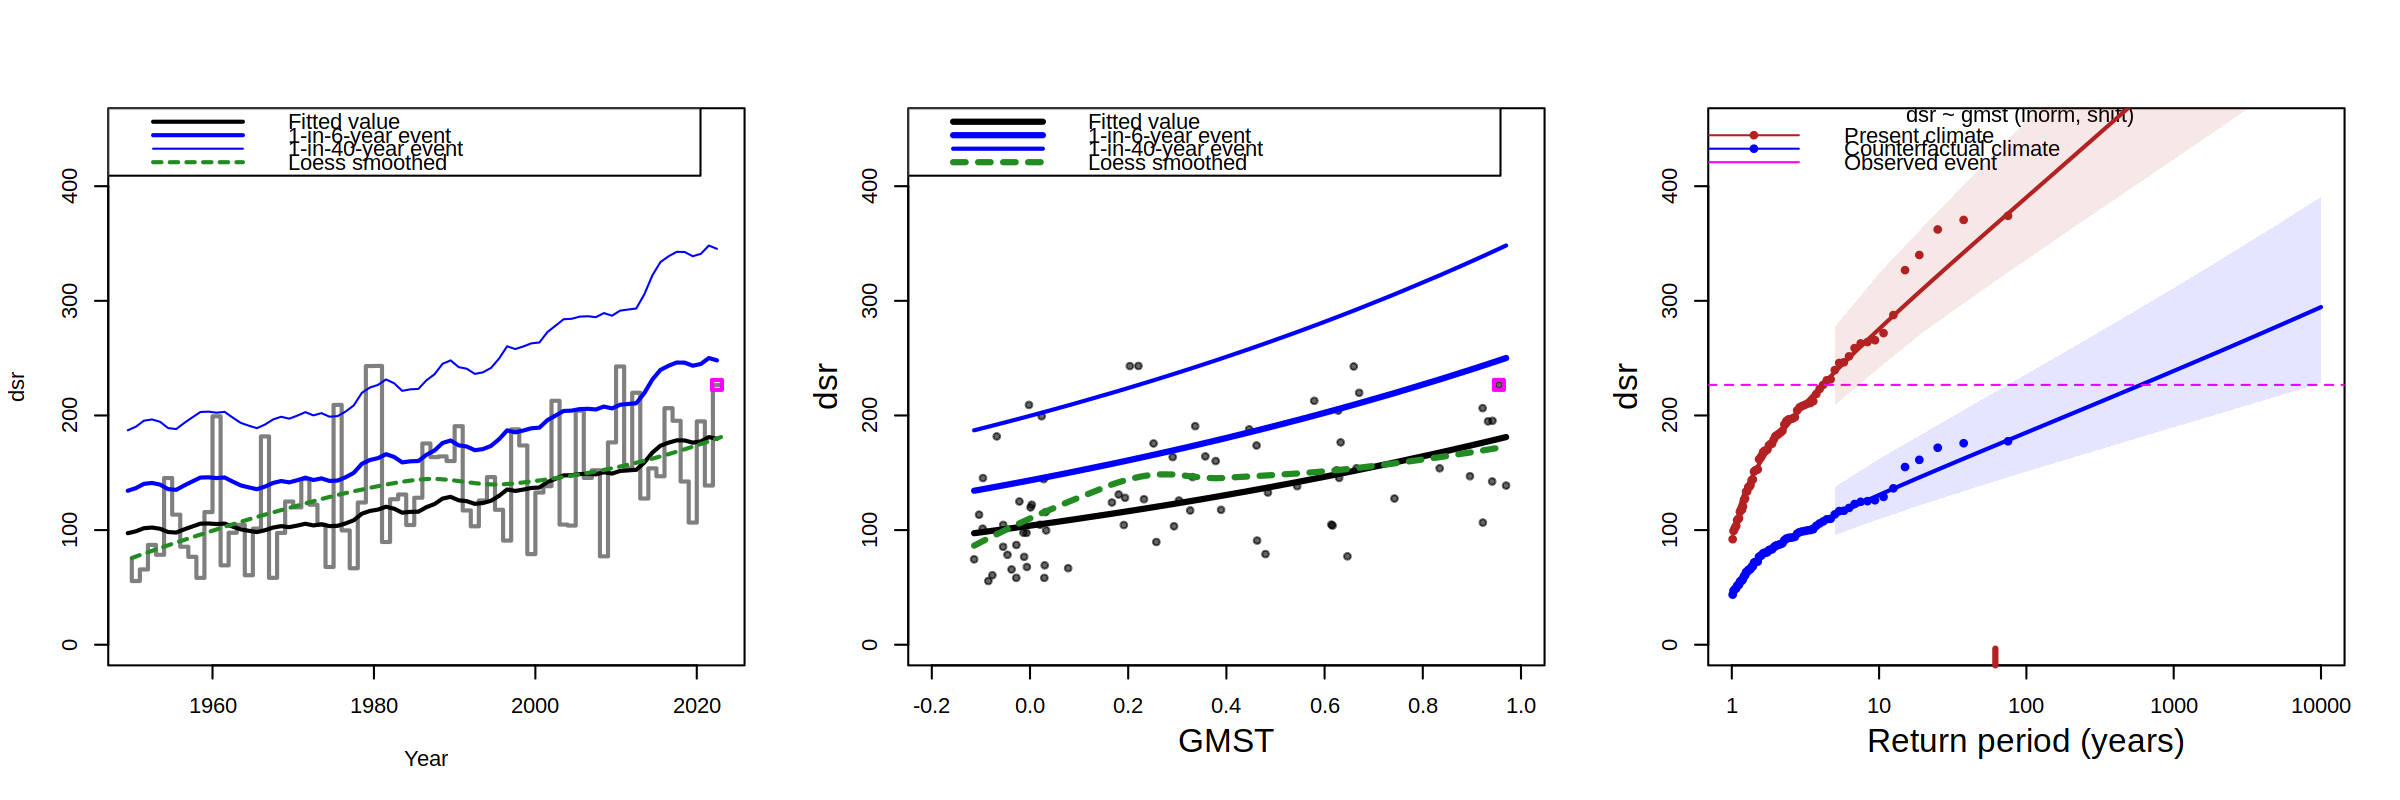

In [6]:
prep_window(c(1,3))
ylim <- c(0,450)

plot_trend(mdl_lnorm, ylim = ylim)
plot_covtrend(mdl_lnorm, xcov = "gmst", ylim = ylim, ci_cov = data.frame(gmst = c(0, 1)), nsamp = NA)
plot_returnlevels(mdl_lnorm, ylim = ylim, cov_f = cov_2023, cov_cf = cov_pi, nsamp = 50)